In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

100%|██████████| 9912422/9912422 [00:00<00:00, 71336647.01it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88939569.62it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21365126.34it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15059706.54it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


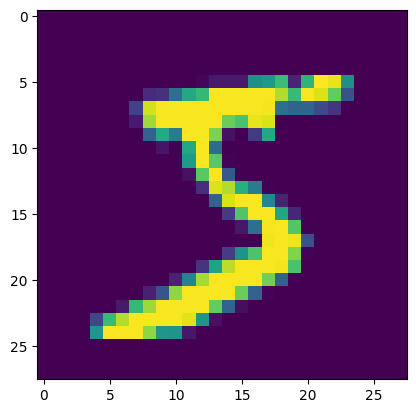

tensor(5)


In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

len(y_train), len(y_test)

import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [3]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

X_train.shape

torch.Size([60000, 1, 28, 28])

In [4]:
class LeNet5(torch.nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.conv1 = torch.nn.Conv2d(
        in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv2 = torch.nn.Conv2d(
        in_channels=6, out_channels=16, kernel_size=5, padding=0)
    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act3 = torch.nn.Tanh()

    self.fc2 = torch.nn.Linear(120, 84)
    self.act4 = torch.nn.Tanh()

    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self, x):

    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x
lenet5 = LeNet5()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [6]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(0):
  order = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    X_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)

    preds = lenet5.forward(X_batch)

    loss_value = loss(preds, y_batch)
    loss_value.backward()

    optimizer.step()

  test_preds = lenet5.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test).data.cpu())

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
  test_accuracy_history.append(accuracy)

  print(accuracy)

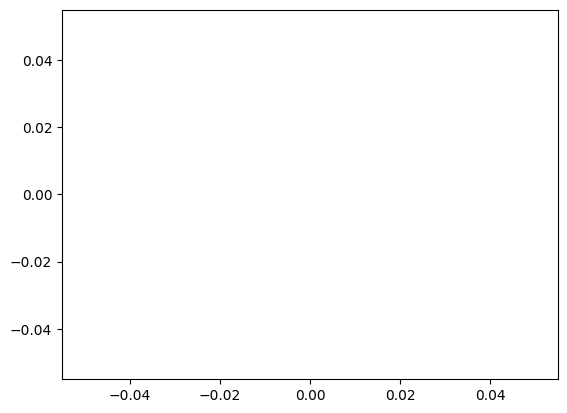

In [7]:
lenet5.forward(X_test)

plt.plot(test_loss_history)

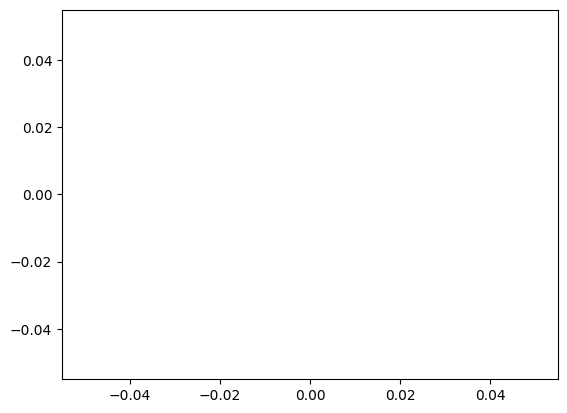

In [8]:
plt.plot(test_accuracy_history)